## 0.0 Intoduction
Research Qs & hypothesis :

RQ:What are the peak posting times on Mastodon?

hypos:
Most posts are published during mid-day (12 PM–4 PM).


## 1.0 Import libraries & prerequsites

In [25]:
from datetime import datetime, timedelta, timezone
from mastodon import Mastodon
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")


In [2]:
pip install --upgrade Mastodon.py

Note: you may need to restart the kernel to use updated packages.


In [3]:
with open('token.txt', 'r') as file:
    ACCESS_TOKEN = file.read().strip()

In [4]:

mastodon = Mastodon(
    access_token=ACCESS_TOKEN,
    api_base_url='https://mastodon.social'
)

print("Connected to Mastodon API")

Connected to Mastodon API


### 1.1 Testing connection 

In [5]:
me = mastodon.account_verify_credentials()
print(me['username'], "is authenticated")


deenakhlewi is authenticated


## 2.0 Collect data

### 2.1 define time window

In [6]:
end_date = datetime.now(timezone.utc)
start_date = end_date - timedelta(days=30)
print("Collecting posts from", start_date, "to", end_date)

all_posts = []


### 2.2 Fetching posts

In [8]:
#Fetch Many Public Posts (with pagination)
print("Collecting posts...")

all_posts = []
max_id = None  # used to paginate through older posts

while len(all_posts) < 2000: 
    posts_batch = mastodon.timeline_public(limit=40, max_id=max_id)

    if not posts_batch:
        break  # stop when there are no more posts available

    for post in posts_batch:
        content_html = post.get('content', '')
        content_text = BeautifulSoup(content_html, 'html.parser').get_text()

        all_posts.append({
            'username': post['account']['username'],
            'created_at': post['created_at'],
            'content_length': len(content_text),
            'reblogs': post['reblogs_count'],
            'favorites': post['favourites_count']
        })

    # move to the next "page" of older posts
    max_id = posts_batch[-1]['id']

    print(f"Collected so far: {len(all_posts)} posts")

print(f"Finished collecting {len(all_posts)} posts!")

#Create DataFrame 
df = pd.DataFrame(all_posts)
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', utc=True)
df['hour'] = df['created_at'].dt.hour
df['engagement'] = df['reblogs'] + df['favorites']






Collected so far: 40 posts
Collected so far: 80 posts
Collected so far: 120 posts
Collected so far: 160 posts
Collected so far: 200 posts
Collected so far: 240 posts
Collected so far: 280 posts
Collected so far: 320 posts
Collected so far: 360 posts
Collected so far: 400 posts
Collected so far: 440 posts
Collected so far: 480 posts
Collected so far: 520 posts
Collected so far: 560 posts
Collected so far: 600 posts
Collected so far: 640 posts
Collected so far: 680 posts
Collected so far: 720 posts
Collected so far: 760 posts
Collected so far: 800 posts
Collected so far: 840 posts
Collected so far: 880 posts
Collected so far: 920 posts
Collected so far: 960 posts
Collected so far: 1000 posts
Collected so far: 1040 posts
Collected so far: 1080 posts
Collected so far: 1120 posts
Collected so far: 1160 posts
Collected so far: 1200 posts
Collected so far: 1240 posts
Collected so far: 1280 posts
Collected so far: 1320 posts
Collected so far: 1360 posts
Collected so far: 1400 posts
Collected s

In [9]:
#Save Raw Data 
df.to_csv("mastodon_posts.csv", index=False)
print("Saved all posts to mastodon_posts.csv")

Saved all posts to mastodon_posts.csv


In [12]:
#Analysis 
# Convert created_at to datetime (if it isn't already)
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract the day of the week (e.g. Monday, Tuesday, etc.)
df['day_of_week'] = df['created_at'].dt.day_name()

# Group by day of week and count posts
posts_per_day = df.groupby('day_of_week').size().sort_values(ascending=False)

print(posts_per_day)


day_of_week
Thursday     1997
Wednesday       2
Tuesday         1
dtype: int64


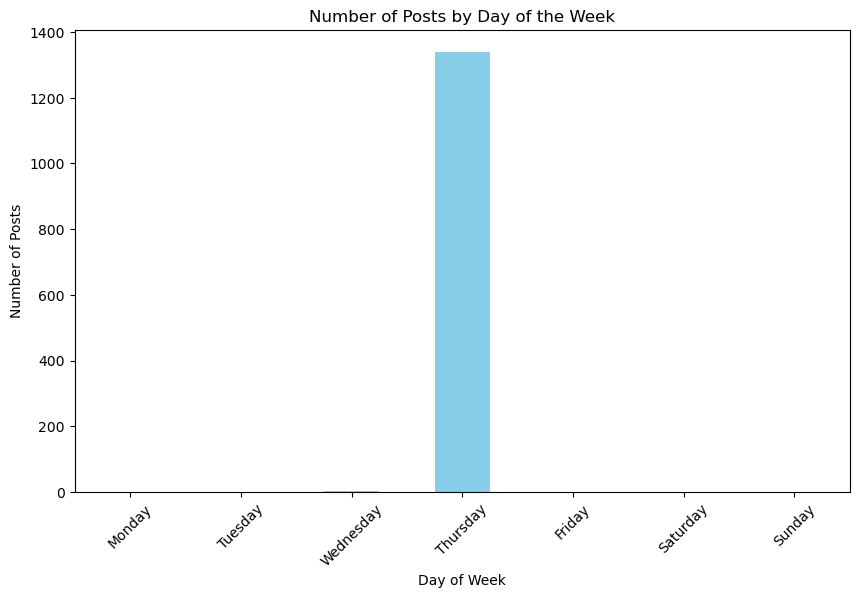

In [40]:

# Example Series (replace this with your actual 'posts_per_day')
posts_per_day = df['day_of_week'].value_counts()  # or use your existing Series

# Optional: order the days correctly
from pandas.api.types import CategoricalDtype
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
posts_per_day = posts_per_day.reindex(weekday_order).fillna(0)  # fill missing days with 0

# Plot
plt.figure(figsize=(10,6))
posts_per_day.plot(kind='bar', color='skyblue')
plt.title('Number of Posts by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

In [11]:
print(df.columns)


Index(['username', 'created_at', 'content_length', 'reblogs', 'favorites',
       'hour', 'engagement'],
      dtype='object')


In [ ]:
df = pd.read_csv("../data/mastodon_posts.csv")
df.head()

,username,created_at,content_length,reblogs,favorites,hour,engagement
0,GlacierMedia,2025-11-11 17:30:00+00:00,271,0,0,17,0
1,www.thisismoney.co.uk.ns.mchannel.rss.ns.campa...,2025-11-13 18:35:49+00:00,390,0,0,18,0
2,LilyBones,2025-11-13 18:35:48+00:00,106,0,0,18,0
3,GoodHouseUK,2025-11-13 16:25:00+00:00,308,0,0,16,0
4,leahfromsd.bsky.social,2025-11-13 18:35:29.118000+00:00,117,0,0,18,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        2000 non-null   object
 1   created_at      2000 non-null   object
 2   content_length  2000 non-null   int64 
 3   reblogs         2000 non-null   int64 
 4   favorites       2000 non-null   int64 
 5   hour            2000 non-null   int64 
 6   engagement      2000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 109.5+ KB


In [33]:
# Robust parsing using 'errors' and 'infer_datetime_format'
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', utc=True, infer_datetime_format=True)

# Drop any rows that failed to parse
df = df.dropna(subset=['created_at'])

# Extract hour and day of week
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.day_name()

# Optional: order weekdays
from pandas.api.types import CategoricalDtype
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['day_of_week'] = df['day_of_week'].astype(CategoricalDtype(categories=weekday_order, ordered=True))

# Group by hour and day
posts_per_hour = df.groupby('hour').size()
posts_per_day = df.groupby('day_of_week').size().reindex(weekday_order)

print("=== Posts by Hour ===")
print(posts_per_hour.sort_values(ascending=False))

print("\n=== Posts by Day ===")
print(posts_per_day.sort_values(ascending=False))



=== Posts by Hour ===
hour
18    1083
17     181
16      37
15      14
13      10
14       7
6        3
12       3
11       2
0        1
23       1
dtype: int64

=== Posts by Day ===
day_of_week
Thursday     1339
Wednesday       2
Tuesday         1
Monday          0
Friday          0
Saturday        0
Sunday          0
dtype: int64


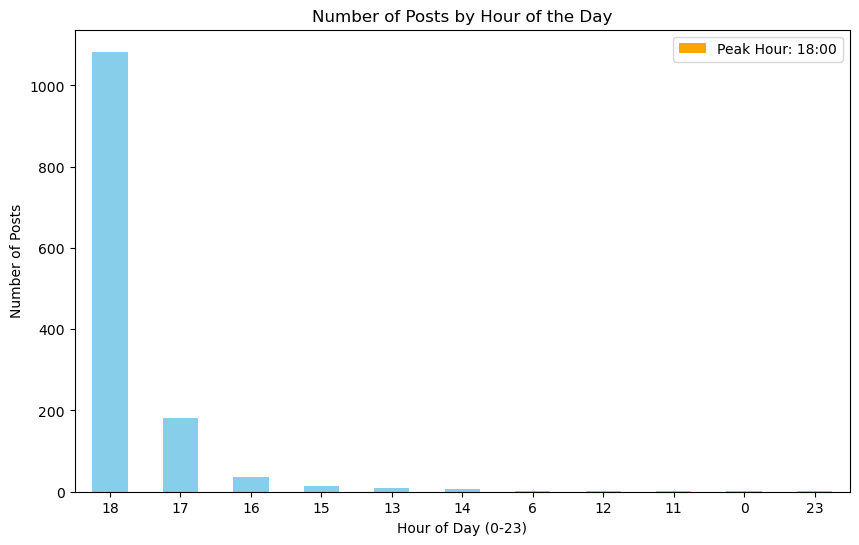

In [38]:
#Visualizations 
plt.figure(figsize=(10,6))
posts_per_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Posts by Hour of the Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)

# Highlight the peak hour
peak_hour = posts_per_hour.idxmax()
plt.bar(peak_hour, posts_per_hour[peak_hour], color='orange', label=f'Peak Hour: {peak_hour}:00')
plt.legend()

plt.show()

In [45]:
df.sample()

,username,created_at,content_length,reblogs,favorites,hour,engagement,day_of_week
1169,schadjoe,2025-11-13 18:31:34+00:00,216,0,0,18,0,Thursday


In [44]:
df.to_csv("../data/mastodon_posts.csv", index=False)
print("Saved all posts to mastodon_posts.csv")

Saved all posts to mastodon_posts.csv
